In [1]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from bs4 import BeautifulSoup
from selenium.webdriver.common.by import By
from tqdm import tqdm_notebook

import pandas as pd
import numpy as np
import time

In [2]:
ser = Service('../chromedriver/chromedriver.exe')
driver = webdriver.Chrome(service = ser)

In [7]:
def get_url(page_num, keyword):
    if page_num == 1:
        url = 'http://search.danawa.com/dsearch.php?k1={}&module=goods&act=dispMain'.format(keyword)
    else:
        url = 'http://search.danawa.com/dsearch.php?query={0}&originalQuery={0}&volumeType=allvs&page={1}&limit=40&sort=saveDESC&list=list&boost=true&addDelivery=N&recommendedSort=Y&defaultUICategoryCode=102207&defaultPhysicsCategoryCode=72|80|81|0&defaultVmTab=2606&defaultVaTab=390097&tab=goods'.format(keyword, page_num)
    return url

In [5]:
def get_multi_page_crawling(total_num, keyword):   
    product_list = []
    for num in tqdm_notebook(range(1,total_num+1)):
        driver.implicitly_wait(3)
        
        driver.get(get_url(num, keyword))
        html = driver.page_source
        soup = BeautifulSoup(html, 'html.parser')
        
        item_list = soup.select('div.prod_main_info')

        for items in item_list:
            try:
                product = items.select('.prod_info > p > a')[0].text
            except:
                pass
        
            try:
                spec = items.select('.spec_list')[0].text.replace('\t','').replace('\n','')
            except:
                pass
        
            try:
                price = int(items.select('.price_sect > a > strong')[0].text.replace(',',''))
            except:
                pass
        
            if '/' in spec and '광고' not in items.text:
                product_list.append([product, spec, price])        

    product_list_pd = pd.DataFrame(product_list, columns = ['상품명', '스펙목록', '가격'])
    return product_list_pd

In [13]:
data = get_multi_page_crawling(10,'기계식키보드')

C:\Users\sara\AppData\Local\Temp/ipykernel_13648/3746020257.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for num in tqdm_notebook(range(1,total_num+1)):


  0%|          | 0/10 [00:00<?, ?it/s]

In [14]:
data.head()

,상품명,스펙목록,가격
0,로지텍 G913 (정품),키보드(일반) / 무선+블루투스 / 내장 배터리 / USB / 용도: 게이밍 / 기...,299000
1,로지텍 G913 TKL (정품),키보드(컴팩트) / 무선+블루투스 / 87키 / USB / 기계식 / 스위치: 독자...,278950
2,로지텍 POP KEYS 무선 기계식 키보드 (정품),키보드(컴팩트) / 무선+블루투스 / 5.1 / AAA형 2개 / USB / 기계식...,113420
3,Razer BlackWidow V3 Mini HyperSpeed KR,키보드(컴팩트) / 유선+무선+블루투스 / 내장 배터리 / USB / 용도: 게이밍...,218990
4,CORSAIR K63 WIRELESS,키보드(컴팩트) / 무선+블루투스 / 4.2 / 내장 배터리 / 87키 / USB ...,159000


In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83 entries, 0 to 82
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   상품명     83 non-null     object
 1   스펙목록    83 non-null     object
 2   가격      83 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 2.1+ KB


In [16]:
data['스펙목록'][0]

'키보드(일반) / 무선+블루투스 / 내장 배터리 / USB / 용도: 게이밍 / 기계식 / 스위치: GL / 키압: 50g / 매크로키 / S/W매크로 / 동시입력: 26키 / 1ms 응답속도 / RGB 백라이트 / 475mm / 150mm / 22mm / 1025g / 2년 보증'

### 데이터 가공하기
1. 상품명에서 회사명과 모델명 분리하기
2. 스펙목록에서 스위치, 키압, 텐키리스 여부 분리하기

#### 상품명에서 회사명과 모델명 분리하기

In [17]:
company_list = []
product_list = []

for item in data['상품명']:
    company_list.append(item.split(' ')[0])
    product_list.append(' '.join(item.split(' ')[1:]))
    
print(company_list[:5])
print(product_list[:5])

['로지텍', '로지텍', '로지텍', 'Razer', 'CORSAIR']
['G913 (정품)', 'G913 TKL (정품)', 'POP KEYS 무선 기계식 키보드 (정품)', 'BlackWidow V3 Mini HyperSpeed KR', 'K63 WIRELESS']


#### 스펙목록에서 스위치, 키압, 텐키리스여부 분리하기

In [29]:
data['스펙목록'][0].split(' / ')[6].split(': ')[1]

'GL'

In [34]:
switch_list = []
key_pressure_list = []
tenkeyless_list = []

for item in data['스펙목록']:
    switch = None
    key_pressure = None
    tenkeyless = None
    
    for spec in item.split(' / '):
        if '스위치' in spec :
            try :
                switch = spec.split(': ')[1]
            except :
                switch = spec
        if '키압' in spec :
            try:
                key_pressure = float(spec.split(': ')[1].replace('g',''))
            except:
                key_pressure = spec
        if '리스' in spec :
            tenkeyless = spec
            
     
    switch_list.append(switch)
    key_pressure_list.append(key_pressure)
    tenkeyless_list.append(tenkeyless)
    
print(switch_list[:5])
print(key_pressure_list[:5])
print(tenkeyless_list[:5])

['GL', '독자 규격', None, 'RAZER', '체리']
[50.0, 50.0, None, 45.0, None]
[None, '텐키리스 키보드', '텐키리스 키보드', '텐키리스 키보드', '텐키리스 키보드']


#### 통합하여 저장하기

In [35]:
data_pd = pd.DataFrame()
data_pd['회사명'] = company_list
data_pd['모델명'] = product_list
data_pd['가격'] = data['가격'] 
data_pd['스위치'] = switch_list
data_pd['키압'] = key_pressure_list
data_pd['텐키리스여부'] = tenkeyless_list

In [36]:
data_pd

,회사명,모델명,가격,스위치,키압,텐키리스여부
0,로지텍,G913 (정품),299000,GL,50.0,None
1,로지텍,G913 TKL (정품),278950,독자 규격,50.0,텐키리스 키보드
2,로지텍,POP KEYS 무선 기계식 키보드 (정품),113420,None,NaN,텐키리스 키보드
3,Razer,BlackWidow V3 Mini HyperSpeed KR,218990,RAZER,45.0,텐키리스 키보드
4,CORSAIR,K63 WIRELESS,159000,체리,NaN,텐키리스 키보드
...,...,...,...,...,...,...
78,레오폴드,"[삼성카드5.0%할인:61,750원~01/21][61키 블루투스 유/무선 겸용 기계...",3925630,None,NaN,None
79,[해외],징동 키크론 Keychron K2 84키 LED 무선 키보드 기계식 영문각인 75%...,3925630,None,NaN,None
80,[해외],기계식 키보드 유선 무선 게이밍 청축 갈축 적축 블루투스 레오폴드 무접점 공식 RK...,3925630,None,NaN,None
81,COX,기계식키보드 CK600 축교환 청축 COX 양손잡이용 무선마우스 CWM10 - CO...,3925630,None,NaN,None


#### 결측치 제거

In [53]:
clean_data = data_pd.dropna(subset=['키압'])
clean_data

,회사명,모델명,가격,스위치,키압,텐키리스여부
0,로지텍,G913 (정품),299000,GL,50.0,None
1,로지텍,G913 TKL (정품),278950,독자 규격,50.0,텐키리스 키보드
3,Razer,BlackWidow V3 Mini HyperSpeed KR,218990,RAZER,45.0,텐키리스 키보드
5,ASUS,ROG FALCHION NX,209000,독자 규격,45.0,텐키리스 키보드
6,Razer,BlackWidow V3 Pro KR,310000,RAZER,50.0,None
8,한성컴퓨터,TFG ART Wireless 한글,179000,여분 스위치 3개,45.0,텐키리스 키보드
9,웨이코스,씽크웨이 CROAD BK620 턴 블루투스 유무선 기계식 키보드,103290,오테뮤,45.0,None
10,ASUS,ROG FALCHION 영문,209000,체리,45.0,텐키리스 키보드
12,한성컴퓨터,TFG ART Wireless 영문,179000,여분 스위치 3개,45.0,텐키리스 키보드
14,Razer,BlackWidow V3 Pro US,310000,RAZER,50.0,None


#### 시각화하기

In [39]:
from matplotlib import font_manager, rc
import matplotlib.pyplot as plt
import seaborn as sns
import platform

# 그래프에서 한글 표기를 위한 글꼴 변경(윈도우, macOS에 대해 처리)
font_path = ''
if platform.system() == 'Windows': 
    font_path = 'c:/Windows/Fonts/malgun.ttf'
    font_name = font_manager.FontProperties(fname = font_path).get_name()
    rc('font', family = font_name)
elif platform.system() == 'Darwin':
    font_path = '/Users/$USER/Library/Fonts/AppleGothic.ttf'
    rc('font', family = 'AppleGothic')
else: 
    print('Check your OS system')

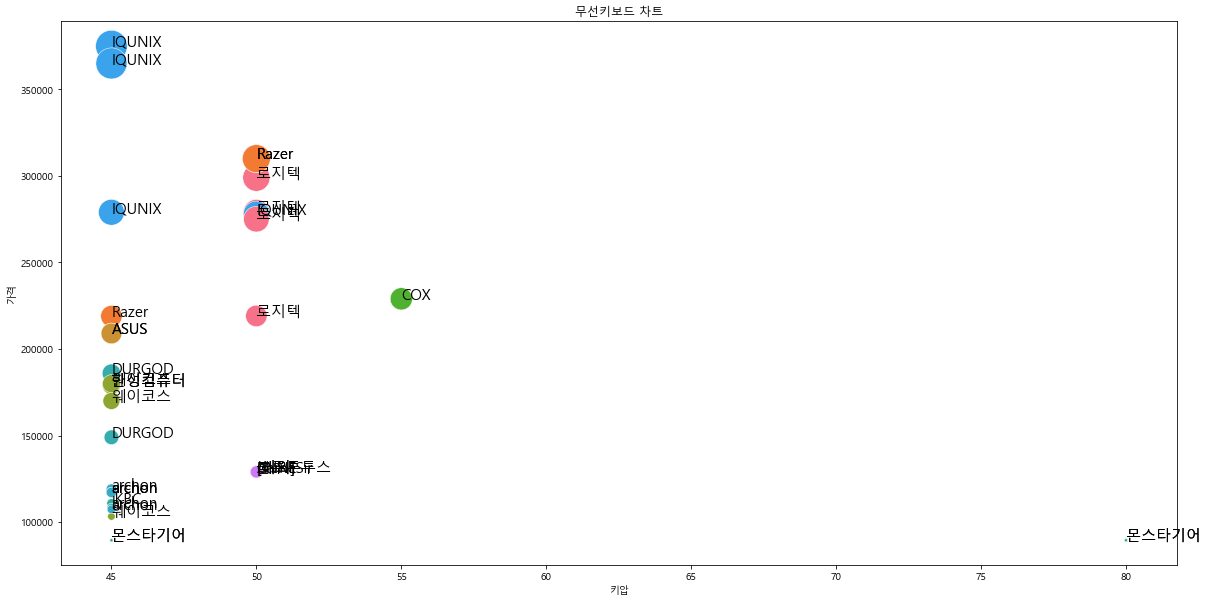

In [59]:
plt.figure(figsize=(20, 10))
plt.title("무선키보드 차트")
sns.scatterplot(x = '키압', y = '가격', size = '가격', hue = clean_data['회사명'], 
             data = clean_data, sizes = (10, 1000), legend = False)
for index, row in clean_data.iterrows():
    x = row['키압']
    y = row['가격']
    s = row['회사명'].split(' ')[0]
    plt.text(x, y, s, size=15)
plt.show()

In [ ]:
plt.figure(figsize=(20, 10))
plt.title("무선 핸디/스틱청소기 TOP 20")
sns.scatterplot(x = '흡입력(W)', 
                  y = '사용시간', 
                  size = '가격', 
                  hue = chart_data_selected['회사명'], 
                  data = chart_data_selected, sizes = (100, 2000),
                  legend = False)
plt.plot([60, suction_max_value], 
          [use_time_mean_value, use_time_mean_value], 
          'r--', 
          lw = 1 )
plt.plot([suction_mean_value, suction_mean_value], 
          [20, use_time_max_value], 
          'r--', 
          lw = 1 )
for index, row in chart_data_selected.iterrows():
    x = row['흡입력(W)']
    y = row['사용시간']
    s = row['제품'].split(' ')[0]
    plt.text(x, y, s, size=15)
plt.show()